In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Hyperparameters
batch_size = 64
lr = 0.001
epochs = 50
patience = 5  # for early stopping

In [ ]:
# Data
transform = transforms.ToTensor()
train_set = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:11<00:00, 889kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.65MB/s]


In [ ]:
# Model (simple)
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

model = SimpleMLP().to(device)


In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        return self.net(x)


model = SimpleMLP().to(device)


In [ ]:
# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
# optimizer with regularization
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)


In [ ]:
#Data augmentation
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1,0.1)),
    transforms.ToTensor()
])


In [ ]:
#  Train & Evaluate function
def evaluate(loader):
    model.eval()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            l = criterion(logits, y)
            loss += l.item() * x.size(0)
            _, pred = torch.max(logits, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return loss/total, correct/total

In [ ]:
#  Training loop with early stopping
train_losses, test_losses = [], []
train_accs, test_accs = [], []
best_loss = np.inf
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        _, pred = torch.max(logits, 1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    train_loss = running_loss/total
    train_acc = correct/total

    test_loss, test_acc = evaluate(test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")

    # early stopping
    if test_loss < best_loss:
        best_loss = test_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered 🚦")
            break

Epoch 1: Train Loss=0.4603, Train Acc=0.8620, Test Loss=0.1736, Test Acc=0.9480
Epoch 2: Train Loss=0.2176, Train Acc=0.9355, Test Loss=0.1245, Test Acc=0.9607
Epoch 3: Train Loss=0.1698, Train Acc=0.9497, Test Loss=0.1081, Test Acc=0.9669
Epoch 4: Train Loss=0.1481, Train Acc=0.9562, Test Loss=0.0982, Test Acc=0.9701
Epoch 5: Train Loss=0.1344, Train Acc=0.9591, Test Loss=0.0934, Test Acc=0.9712
Epoch 6: Train Loss=0.1205, Train Acc=0.9641, Test Loss=0.0820, Test Acc=0.9755
Epoch 7: Train Loss=0.1154, Train Acc=0.9649, Test Loss=0.0770, Test Acc=0.9756
Epoch 8: Train Loss=0.1086, Train Acc=0.9669, Test Loss=0.0758, Test Acc=0.9766
Epoch 9: Train Loss=0.1031, Train Acc=0.9693, Test Loss=0.0759, Test Acc=0.9767
Epoch 10: Train Loss=0.0999, Train Acc=0.9701, Test Loss=0.0745, Test Acc=0.9767
Epoch 11: Train Loss=0.0936, Train Acc=0.9715, Test Loss=0.0738, Test Acc=0.9767
Epoch 12: Train Loss=0.0925, Train Acc=0.9715, Test Loss=0.0740, Test Acc=0.9789
Epoch 13: Train Loss=0.0896, Train Ac

In [ ]:
#  Load best model
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

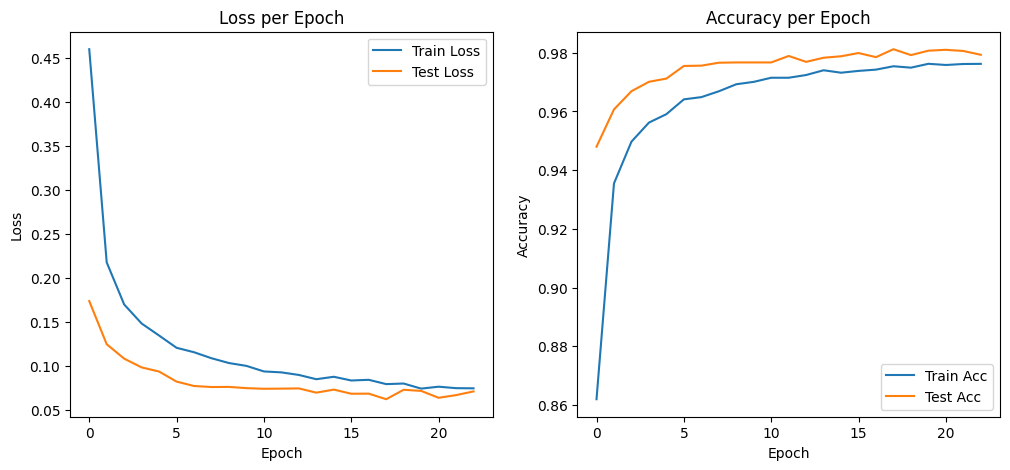

In [ ]:
#  Plot losses & accuracies
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.show()

***********######Classifier using CNN#####***************************

In [ ]:
batch_size = 64
lr = 0.001
epochs = 50
patience = 5  # early stopping
DATA_DIR = "./data"

In [ ]:
#  Data
transform_train = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, translate=(0.2, 0.2), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

transform_test = transforms.ToTensor()

train_set = datasets.MNIST(root=DATA_DIR, train=True, download=True, transform=transform_train)
test_set = datasets.MNIST(root=DATA_DIR, train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [ ]:
#  Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.net(x)

model = SimpleCNN().to(device)

In [ ]:
#  Loss & Optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

In [ ]:
#  Evaluate function
def evaluate(loader):
    model.eval()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            l = criterion(logits, y)
            loss += l.item() * x.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return loss/total, correct/total

In [ ]:
# Training loop
train_losses, test_losses = [], []
train_accs, test_accs = [], []
best_loss = np.inf
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = running_loss/total
    train_acc = correct/total

    test_loss, test_acc = evaluate(test_loader)

    scheduler.step(test_loss)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")

    if test_loss < best_loss:
        best_loss = test_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_cnn_mnist.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("🚦 Early stopping triggered")
            break

#  Load best model
model.load_state_dict(torch.load("best_cnn_mnist.pth"))

Epoch 1: Train Loss=1.3818, Train Acc=0.6349, Test Loss=0.7938, Test Acc=0.9344
Epoch 2: Train Loss=1.0791, Train Acc=0.7955, Test Loss=0.6757, Test Acc=0.9674
Epoch 3: Train Loss=0.9992, Train Acc=0.8371, Test Loss=0.6421, Test Acc=0.9748
Epoch 4: Train Loss=0.9492, Train Acc=0.8617, Test Loss=0.6339, Test Acc=0.9762
Epoch 5: Train Loss=0.9233, Train Acc=0.8749, Test Loss=0.6338, Test Acc=0.9742
Epoch 6: Train Loss=0.8892, Train Acc=0.8918, Test Loss=0.6176, Test Acc=0.9812
Epoch 7: Train Loss=0.8613, Train Acc=0.9038, Test Loss=0.6093, Test Acc=0.9846
Epoch 8: Train Loss=0.8380, Train Acc=0.9143, Test Loss=0.6211, Test Acc=0.9810
Epoch 9: Train Loss=0.8097, Train Acc=0.9257, Test Loss=0.6136, Test Acc=0.9812
Epoch 10: Train Loss=0.7883, Train Acc=0.9331, Test Loss=0.6064, Test Acc=0.9863
Epoch 11: Train Loss=0.7721, Train Acc=0.9388, Test Loss=0.6016, Test Acc=0.9828
Epoch 12: Train Loss=0.7559, Train Acc=0.9433, Test Loss=0.5842, Test Acc=0.9882
Epoch 13: Train Loss=0.7336, Train Ac

<All keys matched successfully>

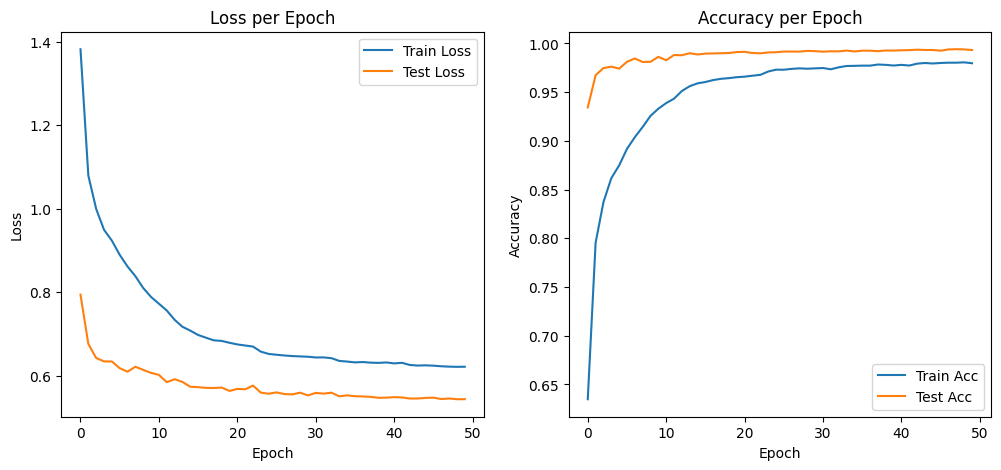

In [ ]:
#  Plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.show()